# My First Artificial Neural Network

**Objective** The goal of this practical session is to implement a simple but fully functional artificial neural network (ANN). It will probably be a first for you so be excited! This session will also be the opportunity to recall some important notions related to Machine Learning. 

**Prerequisites**: introductory level in machine learning, basics of calculus and linear algebra, a first quick introduction to ANNs, basic Python skills, and well, as usual, motivation!

**Estimated time**: 3 hours (generous)

****



## Introduction to the session

You'll be asked to implement several *tricky* details by hand. 
It will (i) force you to deeply understand the basics of neural neworks, and (ii) help you to fully understand what's happening under the hood when you'll be using high-level frameworks such as TensorFlow or PyTorch. 

*Important*: please, don't give up if you find it hard at first, we can ensure you that you've the skills and adapted background to achieve this (easily). Take your time, find your pace, try to fully understand what we are doing at each step.

As we will see later introducing PyTorch (a framework commonly used to implement ANN you're not supposed to know yet), the development process of our ANNs will be highly simplified. But for now, we will only use the Numpy library to implement the neural network.

*NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.* https://numpy.org/. It is not a prerequesite to master Numpy to understand the content of this session. The duration of this session has been defined to allow you to spend extra time learning about tools or concepts that we will use, so do not hesite to find extra resources to learn about Numpy for instance. 

This tutorial is based on https://pytorch.org/tutorials/beginner/pytorch_with_examples.html. Several modifications have been made, and extra content added to match, as much as possible, with the content given in this course and your background. 

Recall the terminology:
* supervised machine learning: the setting we will consider in which we do have a set of pairs of the form (input, label), e.g. in a binary classification task related to cancerous tumor detection in image we would have a set of pairs (image, boolean value).
* training set: labeled inputs we will use to train our network. 
* batch: group of input values processed in a iteration. 

Our aim is to obtain a predictive model, here a neural network, able to perform good predictions while used in production. It is important to stress that we don't only want our model to be good on the training set (that would be memorizing); we want our model to provide good predictions on unseen input values too. Our model should therefore generalize well.  

The flow of this session will be the following: 
1. We will define a neural network architecture in accordance with the input data we will have to deal with. Several design choices will be defined arbitrarily at this step.

2. We will define the training procedure that will be used to train the parameters of the networks using training data. You should already be familiar with the training objective classically considered in a supervised setting (i.e. minimizing a loss function; if it's not the case do not hesitate to go back to our introductory course about linear models).


## Context : Supervised setting, Regression

First we will define the context we will consider.

We will place ourself in a regression setting in which we want a predictor $\hat{f} :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$.

For this illustration we will consider that we have the (x,y,z) coordinates of an object at time $t$ and that we want to predict its coordinates at time $t+1$, not knowing the dynamics of the underlying system (i.e. how the objects move in the corresponding 3D space). 

Our model should therefore be able to take inputs of the form $x_i \in \mathbb{R}^{3}$ and to produce outputs $\hat{y}_i \in \mathbb{R}^{3}$ such that $\hat{y}_i \approx y_i$. Note that we distinguish the expected output (i.e. label) for $x_i$, denoted $y_i$, from the prediction of our network denoted $\hat{y}_i$.

For pedagological reasons, we will arbitrarily and explicitly define the function ($f :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$) we would like to approximate or find using our network. This function will be used to generate the datasets we will use. It is however important for you to understand that you'll never have access to that function in practice; you'll be only given the training set. 

In [2]:
# -*- coding: utf-8 -*-
import numpy as np

theta = 45

# our labeling function
def x_axis_theta_rotation(p):
  """ return new (x,y,z) coordinates of the point after a theta-based rotation along the x-axis
      Note: understanding this function is not important. 
      We could also add a random noise
  """
  return np.array([
    p[0],
    p[1]*np.cos(p[0] * theta) - p[2]*np.sin(p[0] * theta),
    p[1]*np.sin(p[0] * theta) + p[2]*np.cos(p[0] * theta)
  ])

# Generate a label example
x_1 = np.random.randn(3)
y_1 = x_axis_theta_rotation(x_1)

print("Input data example")
print("x_1", x_1)
print("y_1", y_1)


Input data example
x_1 [0.68276457 0.49558762 0.95127517]
y_1 [0.68276457 0.98837687 0.41670457]


We will have several observations of this form. 
Let's say we have *N* observations.

In [3]:
def get_dataset(N, D_in, D_out):

  """Create N random input and associated label"""
  x = np.random.randn(N, D_in)
  y = np.array([x_axis_theta_rotation(xi) for xi in x]) 

  return (x,y)

N = 1000 # size of the dataset
D_in, D_out = 3, 3 # input and output dimensions, we name them to distinguish them hereafter

x, y = get_dataset(N, D_in, D_out)

print(x.shape)

print("Data (first 10 elements)")
print("Inputs\n", x[:10,:])
print("Labels\n", y[:10,:])

print("\nExample")
print("input 1: ", x[0])
print("label 1: ", y[0])

(1000, 3)
Data (first 10 elements)
Inputs
 [[-1.79993156 -1.30395984  0.37734186]
 [ 2.1083672  -0.69017987 -2.63113985]
 [-0.11220212  1.99856636  0.29723976]
 [-1.81803114  0.13031872  0.96726125]
 [ 1.44008502 -2.37533445 -0.12014034]
 [-1.73673633 -1.66949509  0.75271282]
 [ 0.01191135 -2.06511431 -0.68391691]
 [ 0.83115226  1.72210569  0.32357833]
 [-0.42299308  1.48745356 -0.41600044]
 [ 0.31326366 -0.32177886 -1.18680217]]
Labels
 [[-1.79993156 -1.24881744 -0.53212136]
 [ 2.1083672   0.98925761 -2.53389315]
 [-0.11220212  0.37973779  1.98454483]
 [-1.81803114  0.25460193  0.9422076 ]
 [ 1.44008502  1.03817391 -2.13982298]
 [-1.73673633  1.83008975 -0.06754215]
 [ 0.01191135 -1.4262048  -1.64267444]
 [ 0.83115226  1.74135516 -0.19502086]
 [-0.42299308  1.38545974 -0.68269742]
 [ 0.31326366  1.1728736  -0.36933527]]

Example
input 1:  [-1.79993156 -1.30395984  0.37734186]
label 1:  [-1.79993156 -1.24881744 -0.53212136]


## ANN: Feedforward Neural Network

### The Model

We define the architecture of our network, which can be based on several hyperparameters (number of neurons, layers, activation functions...).

We will consider a very simple network composed of a single hidden layer with $H$ neurons using the Relu activation function.

***

#### Rectified Linear Unit (ReLU)

ReLU is a popular [activation function](https://en.wikipedia.org/wiki/Activation_function) that can be used while defining an artificial neuron. 

$\phi(z) = max(0,z)$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Rectifier_and_softplus_functions.svg/500px-Rectifier_and_softplus_functions.svg.png" alt="ReLU" width="300"/>

***
By convention, we consider inputs to be row vectors (cf. $x \in \mathbb{R}^{N \times D_{in}}$). 

Input $i$: $x_i \in \mathbb{R}^{1 \times 3}$ 

The predictive function $\hat{f} :\mathbb{R}^{3} \rightarrow \mathbb{R}^{3}$  (our neural network) will be:

$\hat{f}(x_i) = \hat{y}_i = relu(x_i W_{1}) W_{2}$ 

with: 
* $W_{1} \in \mathbb{R}^{3 \times H}$
* $relu(z) = [max(0,z_0),max(0,z_1), ...]$  
* $W_{2} \in \mathbb{R}^{H \times 3}$

In this simple model we do not consider bias. 

Note also that setting the number of neurons in this single-layer network, the predictions are deterministically determined by the weights $W_{1}$ and $W_{2}$. It means that the outputs of our model are fully determined by the weights of the network. Those are the sole parameters of our simple MLP (Multilayer Perceptron) model. 

Note also that we can use this network on a batch of inputs.
with $x = [x_0, x_1, ..., x_N]^T \in \mathbb{R}^{N \times 3}$.

In the following we will therefore consider: 

$\hat{f} :\mathbb{R}^{N \times 3} \rightarrow \mathbb{R}^{N \times 3}$



### First implementation


> **Exercice "Forward pass"**:
> 
> The forward pass of a network is used to compute the outputs for a batch of inputs (see $\hat{f}$ definition above).
> 
> Considering thes simple MLP model we defined, we ask you to implement the forward pass using Numpy.
> 
> Instructions:
> * According to our task, both the input and the output must be in $\mathbb{R}^{N \times 3}$. You'll denote $D_{in}$ and $D_{out}$, respectively `D_in` and `D_out` the input and output dimensions. As we already said, we here have $D_{in}=D_{out}=3$, but we want our network to be generic so reuse existing `D_in` and `D_out` variables. 
> * Define a variable `H` to set the number of neurons; we want to be able to modify it.
> * Initialize the weights randomly considering a standard normal distribution (mean=0, stdev=1). 
> * Decompose each step of the forward pass, i.e., do not use a fancy one-line expression. Only use Numpy functions to implement each step.
> * Do not define a class now, just code it into a cell.




In [9]:
D_in, D_out = 3, 3
H = 100 #set 100 neurons

#initializing random weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)
print(w1, w2)

#forward pass
h = x @ w1 
h_relu = np.maximum(0, h)
y_pred = h_relu @ w2

print(y_pred)



[[ 0.38873991  0.30423318  0.98061864  0.68800225  2.1124912  -0.68371999
  -0.08777996 -2.14742613 -0.72189652 -0.72548667 -0.57859974 -0.04834429
   1.13061805  0.8929775  -0.65675058 -0.04860546  0.81848168 -0.44627841
  -1.54438716 -0.21301029  1.64340546 -0.11717445  0.29401115  0.01154062
  -0.13605263 -1.98743131 -0.96650479 -0.0826066  -0.46383769  0.54439204
   0.85419758  0.13124704  0.97650244 -0.85421039 -0.87698778 -0.941925
   0.15687616  0.3449859  -0.23991183  0.13910483 -0.40747605  0.0640728
   0.23589365  0.92573963  1.08783257 -0.7324608  -1.21775041  0.83652332
   0.01572257 -1.15167382 -1.23312634 -0.97417055  0.9755757   0.04828365
  -0.24440999  0.83922266 -0.44575234  0.5109142   0.22013797 -0.89809364
  -0.35179762 -0.61612767 -1.0918398   0.95741808  0.76244854  1.5634177
   0.14173852  0.09951762  0.35222865  0.56473802  1.93125441 -0.05826745
  -0.28288236  0.49483195 -1.43875004  0.48081702  0.37786628 -0.66589951
   0.96913335  1.28026257  0.00703551  0.2

Obviously, the weights being randomly defined, do not expect to have good predictions at this stage. 

Our job will now be to define a clever procedure to train those parameters in order to obtain a good predictor. 

## Training procedure



### Generalities 

Training the network will aim at finding the $W_{1}$ and $W_{2}$ matrices in order to minimize the loss function, i.e. the function we will use to evaluate the error of our model.

This error function (loss function) will be defined this way: 

$l(\hat{y}, y) = \sum_{i=0}^{N-1} \sum_{j=0}^{D_{out}-1} (\hat{y}_{i,j} - y_{i,j})^2$

*Important*: note that loss function only makes sense in a regression setting. 

with $\hat{y}, y \in \mathbb{R}^{N \times D_{out}}$

Processing the data, the weights will be iteratively modified in order to reduce the loss.

To do so, at each iteration, we will apply two passes: 
1. Forward pass: compute the loss for the processed input (it can be a subset of the whole training set or even one input). We already know how to do that (see above).
2. Backward pass: as we know the expected value for each input processed during the training phase, we can compute the loss for the current set of predictions. As we want to minimize that loss, we will:
  *  Compute the partial derivative of the loss with regards to the parameters (here $W_{1}$ and $W_{2}$), also named [gradients](https://en.wikipedia.org/wiki/Gradient) and denoted in our case $\nabla_{W_1}$ and $\nabla_{W_2}$. Those gradients will denote the direction of greatest increase of the loss, and can therefore be used to change the parameters to influence the loss (following the opposite direction, we will be able to iteratively minimize the loss). To compute this gradient, we will simply apply the chain rule considering that all functions used in our network have a derivative (chain rule: https://en.wikipedia.org/wiki/Chain_rule) - please put aside consideration induced by the relu function for now, that's not important.
  * Adjust the parameters ($W_{1}$ and $W_{2}$) applying an update rule based on the gradient, e.g. considering a constant pre-defined learning rate $\eta$, this rule could be $W_1 = W_1 - \eta \times \nabla_{W_1}$. This is called backpropagation. 

Computing the gradients is probably the most technical part, but it should not be a problem as it only requires to compute derivative.
We provide a sketch to compute $\nabla_{W_2}$ (using shortcut notations):



$\frac{\partial l}{\partial W_2} = \frac{\partial l}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial W_2}$

$\frac{\partial l}{\partial \hat{y}} = 2 (\hat{y} - y)$ $\in \mathbb{R}^{N \times D_{out}}$ 

$\frac{\partial \hat{y}}{\partial W_2} : relu(x_i W_{1})$ $\in \mathbb{R}^{N \times H}$ (shortchut)

$\frac{\partial l}{\partial W_2} =  relu(x_i W_{1})^T \cdot (2 (\hat{y} - y))$ $\in \mathbb{R}^{H \times D_{out}}$, recall that $W_2 \in \mathbb{R}^{H \times D_{out}}$ 

Details on how to compute the gradient on linear models (considering multivariate calculus) are provided in that resource: https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html


### First implementation

> **Exercise: Training procedure implementation**
>
> You can now try to implement the training procedure

We define below our first implementation of the training procedure

In [10]:
# initializing variables
H = 100
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)
learning_rate = 1e-6

for t in range(50001):
    # do the forward pass
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # calculate square loss
    loss = np.square(y_pred - y).sum()
    if t % 1000 == 0:
      print(t, loss)

    # do the backward pass to adjust weights
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h_relu[h < 0] = 0
    grad_w1 = x.T.dot(grad_h_relu)
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


0 593064.9906353592
1000 2515.662449744261
2000 2199.988555925089
3000 2099.905324874666
4000 2047.1767404105944
5000 2007.9704604362557
6000 1978.1271142330763
7000 1954.7044790202483
8000 1938.1652729646285
9000 1925.263745851707
10000 1914.0753029238842
11000 1904.4905741575371
12000 1896.2345574033748
13000 1888.4159267881673
14000 1882.1796907261742
15000 1876.0773113979385
16000 1870.6153519539153
17000 1865.4711800557807
18000 1861.0203742339977
19000 1857.0712819771463
20000 1853.978600694682
21000 1850.547448024821
22000 1847.1173009306722
23000 1844.064175117086
24000 1841.1324613487475
25000 1838.6491261540373
26000 1836.351552573351
27000 1833.829912002415
28000 1831.8153863028988
29000 1830.0568492481411
30000 1828.4456083447599
31000 1826.8515155378775
32000 1825.3110655826974
33000 1823.8151376648557
34000 1822.3588427848274
35000 1820.9290888063074
36000 1819.5043471236863
37000 1817.8880142274882
38000 1816.4177068408487
39000 1815.0429195720071
40000 1813.867360614948

As we can see, it looks like our network is learning something. 

To be more precise, the training procedure we defined enables to iteratively minimize the loss (on the training set). 

## Refactoring / Refinements

Let's restructure the code in order to distinguish the different parts.
Several approaches could have been chosen (and a lot of choices could be discussed and questioned in term of design, but that's not the aim of the course). 

### Model implementation


> **Exercise: refactoring**
>
> Refactor the code. Create a class `SimpleANN` with a constructor enabling to define $D_{in}$, $D_{out}$, $H$.
>
> Define a `forward` method in which you'll implement the forward pass (the method returns the prediction).

In [12]:
#keeping the same notation for the variables

class ANN :
    """
    the ANN is a class which permits predicting the three values
    """
    def __init__(self, H: int, D_in: int, D_out: int):
        #init the weights randomly
        self.w1 = np.random.randn(D_in, H)
        self.w2 = np.random.randn(H, D_out)
    
    def forward(self, x):
        h = x @ self.w1
        h_relu = np.maximum(0, h)
        y_pred = h_relu @ self.w2

        return y_pred

### Trainer implementation

In [14]:
class Trainer:
  """
    the Trainer is a class which permits adjust the weights of ANN class
  """

  def __init__(self, ann: ANN, training_set):
    self.learning_rate = 1e-6 
    self.ann = ann
    self.x, self.y = training_set

  #calculate the square loss error
  def compute_loss(self, y_pred, y):
    return np.square(y_pred - y).sum()
    

  def step(self):
    y_pred = self.ann.forward(self.x)
    loss = self.compute_loss(y_pred, self.y)
    
    # backward step
    h = self.x.dot(self.ann.w1)
    h_relu = np.maximum(h, 0)
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(self.ann.w2.T)
    grad_h_relu[h < 0] = 0
    grad_w1 = self.x.T.dot(grad_h_relu)
    self.ann.w1 -= self.learning_rate * grad_w1
    self.ann.w2 -= self.learning_rate * grad_w2

    return loss

  def fit(self, epoch: int, log_frequency: int):
    log_loss = [] # we just log the loss
    for i in range(epoch+1):
      loss = self.step()
      if i % log_frequency == 0:
        print(i, loss)
        log_loss.append((i,loss))
    return log_loss

### Training tests

We can now easily reimplement the training loop

0 636110.9547903754
1000 2495.222429915454
2000 2238.324581222505
3000 2135.9493308267774
4000 2074.870667457689
5000 2030.7580831855585
6000 1997.573783129069
7000 1969.1069730392855
8000 1949.31973410875
9000 1934.5891601739659
10000 1922.0745105899366
11000 1911.7540691375366
12000 1903.077008511406
13000 1895.6243024220782
14000 1888.1846609737308
15000 1881.6711643339795
16000 1876.069805660961
17000 1870.7025454756645
18000 1865.3180650499944
19000 1859.2425870513375
20000 1853.3108548821556


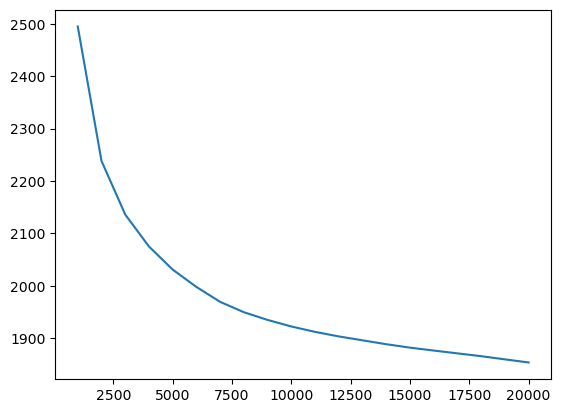

In [15]:
ann = ANN(H=H, D_in=3, D_out=3)
trainer = Trainer(ann, (x, y))
log_loss = trainer.fit(epoch=20000, log_frequency=1000)

# plotting
import matplotlib.pyplot as plt
del log_loss[0] # we remove the first loss (random weights)
res = list(zip(*log_loss)) 
plt.plot(res[0], res[1])

Let's see how our neural network performes on unseen data : the only things that matters for us.

To do so we will generate another set of labelled data not used during training.

In [35]:
#prediction on the train dataset
y_pred = ann.forward(x)
training_loss = trainer.compute_loss(y_pred, y)

#prediction on a unknown dataset
x_test, y_test = get_dataset(N, D_in, D_out)
y_pred_test = ann.forward(x_test)
test_loss = trainer.compute_loss(y_pred_test, y_test)

#difference of performances between test and train dataset
print("training loss: ", training_loss)
print("test loss    : ", test_loss)
print("diff         : ", abs(training_loss - test_loss))

training loss:  1853.305072936229
test loss    :  2203.1820089676185
diff         :  349.8769360313895


Well... even if results may vary from run to run, it looks like our neural network is pretty good on the training set but fails to perform similarly on the test set... we don't like this at all.
We are maybe overfitting, i.e. memorizing the training set. 

### Train, Validation, Test 



To monitor, and eventually overcome this, we will split our initial labelled dataset into 3 parts: 
* training set: the data we will use to update the weights of our network
* validation set: the data we will use to monitor that we are not overfitting the training set during training
* test set: the data we will use to evaluate our trained ANN on data not used during the training phase

We will monitor our loss on the validation set during training and stop when the difference between our training and validation losses stresses overfitting.

We will modify our trainer to accept a validation set. 

In [36]:
class TrainerAdvanced(Trainer):
  """
    Simple Trainer with validation
  """

  def __init__(self, ann: ANN, training_set, validation_set):
    Trainer.__init__(self, ann, training_set)
    self.x_val, self.y_val = validation_set
    
  def fit(self, epoch: int, log_frequency: int):

    log_loss = [] # we just log the losses

    for i in range(epoch+1):
      
      loss_train = self.step()

      if i % log_frequency == 0:

        # validation part
        y_pred_val = self.ann.forward(self.x_val)
        loss_val = self.compute_loss(y_pred_val, self.y_val)

        log_loss.append((i, loss_train, loss_val))
        loss_train_evol = 0 if len(log_loss) == 1 else loss_train - log_loss[len(log_loss)-2][1]
        loss_val_evol = 0 if len(log_loss) == 1 else loss_val - log_loss[len(log_loss)-2][2]
        
        print("{} train: {:.2f}   valid: {:.2f}   diff: {:.2f}   loss train ev.: {:.2f}   loss val ev.: {:.2f}".format(i, loss_train, loss_val, loss_train - loss_val, loss_train_evol, loss_val_evol))
    return log_loss 

Let's train our model using that new Trainer.

Note that we already have a training set, and test set. 
We will only create a validation. 
Generally you'll have to split an initial dataset to obtain those sets.

0 train: 1853.31   valid: 2317.76   diff: -464.45   loss train ev.: 0.00   loss val ev.: 0.00
1000 train: 1847.97   valid: 2318.63   diff: -470.65   loss train ev.: -5.33   loss val ev.: 0.87
2000 train: 1843.66   valid: 2318.35   diff: -474.69   loss train ev.: -4.31   loss val ev.: -0.27
3000 train: 1839.73   valid: 2318.00   diff: -478.27   loss train ev.: -3.93   loss val ev.: -0.36
4000 train: 1835.61   valid: 2317.77   diff: -482.16   loss train ev.: -4.12   loss val ev.: -0.23
5000 train: 1831.33   valid: 2318.02   diff: -486.69   loss train ev.: -4.27   loss val ev.: 0.25
6000 train: 1827.35   valid: 2317.98   diff: -490.63   loss train ev.: -3.99   loss val ev.: -0.04
7000 train: 1823.51   valid: 2316.05   diff: -492.54   loss train ev.: -3.83   loss val ev.: -1.93
8000 train: 1819.49   valid: 2314.19   diff: -494.70   loss train ev.: -4.03   loss val ev.: -1.87
9000 train: 1816.32   valid: 2312.18   diff: -495.86   loss train ev.: -3.17   loss val ev.: -2.01
10000 train: 1813

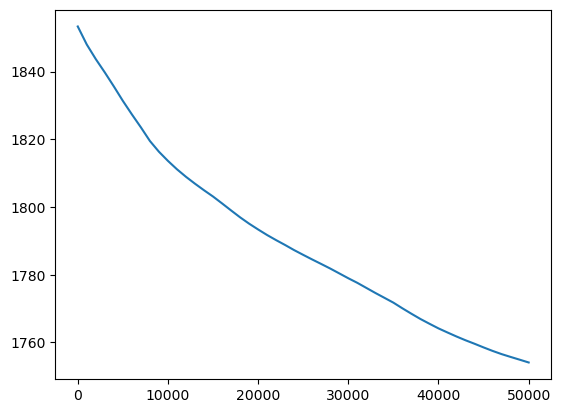

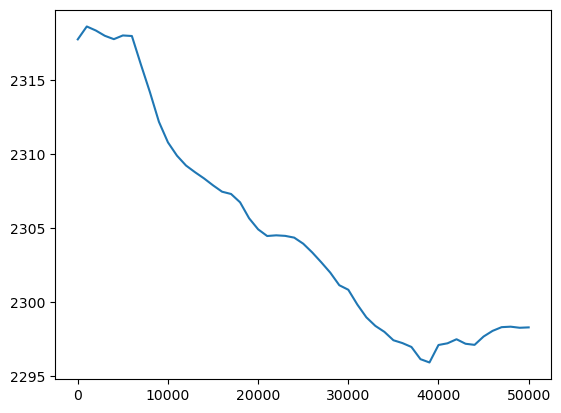

In [37]:
# we use the network already trained above

#ann = ANN(D_in=3, D_out=3, H=H)

x_val, y_val = get_dataset(N, D_in, D_out)

assert x.shape[0] == x_val.shape[0]

trainer = TrainerAdvanced(ann, (x, y), (x_val, y_val))
log_loss = trainer.fit(epoch=50000, log_frequency=1000)

import matplotlib.pyplot as plt
def plot_losses(log_losses):
  # del log_loss[0] # remove the first loss if you train a new network
  res = list(zip(*log_loss)) 
  plt.plot(res[0], res[1])
  plt.show()
  plt.plot(res[0], res[2])

plot_losses(log_loss)


It looks like we indeed obtain a better loss on the training set compared to the one obtained on the validation set. 

But we are still reducing the validation loss during training (which means we are not overfitting per se).

Let's continue training.

0 train: 1792.02   valid: 2160.64   diff: -368.62   loss train ev.: 0.00   loss val ev.: 0.00
5000 train: 1790.06   valid: 2161.76   diff: -371.69   loss train ev.: -1.95   loss val ev.: 1.12
10000 train: 1788.15   valid: 2163.34   diff: -375.19   loss train ev.: -1.91   loss val ev.: 1.58
15000 train: 1786.31   valid: 2164.25   diff: -377.94   loss train ev.: -1.84   loss val ev.: 0.91
20000 train: 1784.52   valid: 2164.44   diff: -379.91   loss train ev.: -1.79   loss val ev.: 0.19
25000 train: 1782.68   valid: 2165.67   diff: -382.99   loss train ev.: -1.84   loss val ev.: 1.23
30000 train: 1781.05   valid: 2166.28   diff: -385.23   loss train ev.: -1.63   loss val ev.: 0.61
35000 train: 1779.52   valid: 2166.33   diff: -386.81   loss train ev.: -1.53   loss val ev.: 0.05
40000 train: 1778.00   valid: 2166.42   diff: -388.42   loss train ev.: -1.52   loss val ev.: 0.09
45000 train: 1776.55   valid: 2166.62   diff: -390.07   loss train ev.: -1.45   loss val ev.: 0.20
50000 train: 177

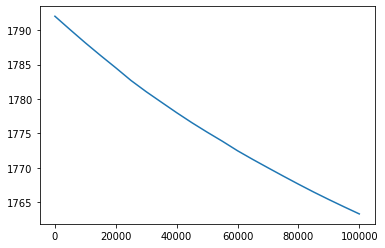

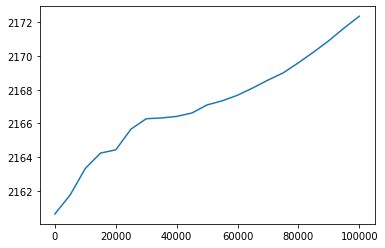

In [ ]:
log_loss = trainer.fit(epoch=100000, log_frequency=5000)
plot_losses(log_loss)

[Optional] Execute the code below to plot the full evolution of the losses training a new network from scratch

0 train: 584739.53   valid: 434245.68   diff: 150493.84   loss train ev.: 0.00   loss val ev.: 0.00
1000 train: 2728.96   valid: 2799.05   diff: -70.08   loss train ev.: -582010.57   loss val ev.: -431446.64
2000 train: 2345.95   valid: 2505.43   diff: -159.49   loss train ev.: -383.02   loss val ev.: -293.61
3000 train: 2196.78   valid: 2418.73   diff: -221.95   loss train ev.: -149.17   loss val ev.: -86.70
4000 train: 2115.59   valid: 2372.68   diff: -257.09   loss train ev.: -81.19   loss val ev.: -46.05
5000 train: 2063.90   valid: 2349.62   diff: -285.72   loss train ev.: -51.69   loss val ev.: -23.06
6000 train: 2028.66   valid: 2340.15   diff: -311.48   loss train ev.: -35.24   loss val ev.: -9.47
7000 train: 2003.05   valid: 2335.76   diff: -332.71   loss train ev.: -25.61   loss val ev.: -4.38
8000 train: 1983.48   valid: 2332.59   diff: -349.11   loss train ev.: -19.57   loss val ev.: -3.18
9000 train: 1967.08   valid: 2328.85   diff: -361.77   loss train ev.: -16.40   loss 

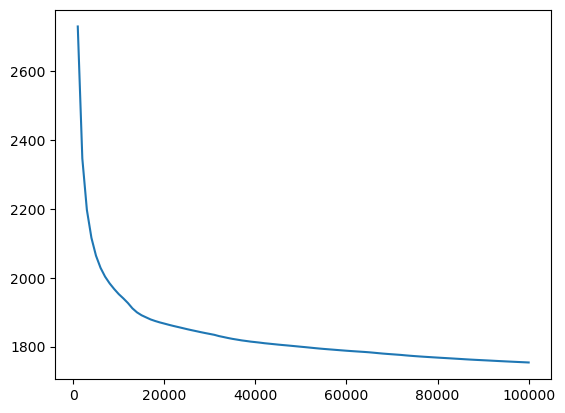

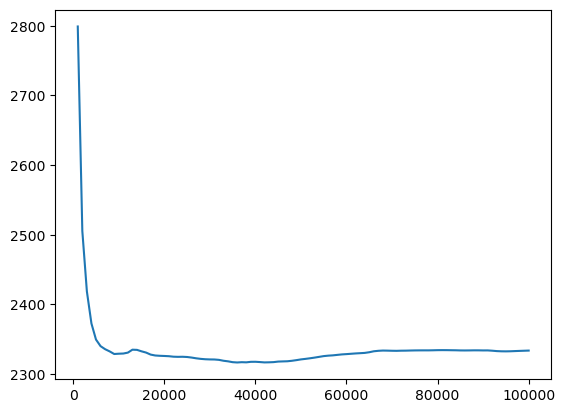

In [38]:
ann = ANN(D_in=3, D_out=3, H=H)
trainer = TrainerAdvanced(ann, (x, y), (x_val, y_val))
log_loss = trainer.fit(epoch=100000, log_frequency=1000)

del log_loss[0]
plot_losses(log_loss)

## Takeaway

You've implemented your first ANN. 

Ok it was a quite simple ANN, but you can still be proud of you!

We will now try extract the main notions you're supposed to grasp having endured that adventure. 

**A task-dependent ANN model with specific design choices**

The architecture of our ANN has been defined based on the task we were adressing. Recall that in our case we were dealing with a specific regression task in which our predictior (ANN) was of the form: $\hat{f}: \mathbb{R}^3 \rightarrow \mathbb{R}^3$. Always keep in mind what's your goal: given the (x,y,z) 3D coordinates of an object at time $t$, we were asked to predict the location of the object in that same space at time $t+1$.

Hence, even if we tried to be as generic as possible, e.g. introducing $D_{in}$ and $D_{out}$ to refer to the input, and output sizes, those values, among others, had to be defined to even think about effectively use the ANN, i.e. to make predictions. This was required to process a given input and produce an output because the shapes of $ W_1 $ and $ W_2 $ were also dependent of these values.

In our case we defined $D_{in} = D_{out} = 3$ because the task we were dealing required us to ($\hat{f}: \mathbb{R}^3 \rightarrow \mathbb{R}^3$). Dealing with another task, e.g. classification task, and/or the need to process other types of inputs, or to produce other outputs would require us to make potentially important modifications to our network. This has to be very clear to you.

Designing our network, we also arbitrarily defined several things related to its architecture : we chose to only use a single hidden layer, with a specific number of neurons ($H$), that were characterized by a similar activation function (Relu). The type of ANN we finally defined is called a [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) (no cycles in the flow of information).

All these design choices could have been different. We could have changed the number of neurons, the number of layers, the activation function, even the connexions between neurons. Once again, those choices had to be defined in order to obtain a usable network, as they define the way the output will be computed from an input. 

Expert in machine learning and deep learning know the litterature generally have an idea of what types of networks are more susceptible to work dealing with a specific task. They also know how to apply well-defined procedures to train various models and compare their results in a meaningfull way, which is always mandatory in the end to train and obtain a new network trained for a specific task on new data.

We therefore distinguish: 
* Type of networks: feedforward, recurrent...
* hyperparameters: number of layers, neurons, types of activation function...
* parameters: weights (and bias) of the network that are effectively trainable (values stored in $W_1$ and $W_2$ in our case).  

The architecture of the network and the hyperparameters define the way the function mapping the input to the output is constrained (it defines a set of functions). 

The parameters are implicitly defined by the design of the network, e.g. in our simple network, the hyperparameters $D_{in}$, $D_{out}$ and $H$ are defining the shapes of the matrices $W_1$ and $W_2$ storing the networks' parameters. 

Once fixed, i.e. assigned to a specific value, the parameters finally fully define the predictor, the function $\hat{f}$ we will be able to use to map an input to an output.     

**The general training procedure is not tight to a specific ANN or Task**

The training procedure has been used to find the good value of the parameters with regard to a specific objective we defined. 

The objective we considered is the minimization a loss function (it get more complex when we distinguish training, validation and test losses but don't get lost, what we wanted was to minimize a loss considering specific constraints). 

Recall, the training procedure we used. 
It worked iteratively as follows: 

* We iterate several times on the training data (eventually processing splits):
  1. Forward pass: The predictor is used to makes predictions on the given inputs.
  2. Backward pass: 
    * We compute the training loss comparing expected values and predictions
    * We compute the gradient of the loss function with respect to the parameters of the ANN.
    * We modify the parameters using the gradient.  
  3. We evaluate a stopping criterion (e.g. based on the loss on a validation set)

Obviously, this is a general sketch and each step contains technical aspects. However, the procedure is fully generic considering that: 
* the ANN is given 
* the loss is defined
* we can compute the gradient of the loss function with respect to the parameters of the ANN (which was in the end the only technical part we had to deal with)


Now, read carefully, let's imagine a world where, considering a loss and a set of labeled inputs, computing the gradient of the loss function with respect to the parameters of an ANN would be as easy as calling a function once the forward pass of the ANN is defined. Read again. 

This world exists, it's yours! 


> **Exercise "Explain me what's an ANN."**
>
> Developing ANNs in the following sessions will require you to master the basic concepts. Take a sheet of paper. 
>  
> Considering a supervised setting:
> * Introduce what's an ANN; distinguish the main components, illustrate and formalize them.
> * Explain how to train an ANN considering a specific dataset.  
> * Express an illustration of simple network using Linear Algebra notations we used in the course (it will be important for you to understand this for the next sessions). 
> 

## Resources 
* [Machine learning](https://en.wikipedia.org/wiki/Machine_learning)
* [Supervised learning](https://en.wikipedia.org/wiki/Supervised_learning)
* [Feedforward neural networks](https://en.wikipedia.org/wiki/Feedforward_neural_network)
* [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)
* [Chain rule](https://en.wikipedia.org/wiki/Chain_rule)


********